In [ ]:
!pip install lightgbm

# Create Synthetic Dataset

In [20]:
import pandas as pd

# Step 1: Generate time series data

data_length = 1440 * 2

np.random.seed(42)
time_points = pd.date_range('2024-01-01', periods=data_length, freq='T')  # 1440 minutes in a day
movement = np.abs(np.sin(np.linspace(0, 24, data_length) * np.pi / 12) + np.random.normal(0, 0.1, data_length))
heart_rate = 60 + movement * 15 + np.random.normal(0, 5, data_length)

time_series_data = pd.DataFrame({'Heart rate': heart_rate, 'Movement': movement}, index=time_points)

# Step 2: Segment data and extract features
# For simplicity, let's consider each hour as a segment
features = []
for i in range(0, time_series_data.shape[0], 60):  # 60 minutes in an hour
    segment = time_series_data.iloc[i:i + 60]
    heart_rate_mean = segment['Heart rate'].mean()
    heart_rate_std = segment['Heart rate'].std()
    movement_mean = segment['Movement'].mean()
    movement_std = segment['Movement'].std()
    features.append([heart_rate_mean, heart_rate_std, movement_mean, movement_std])

feature_vectors = pd.DataFrame(features, columns=['Heart rate mean', 'Heart rate std', 'Movement mean', 'Movement std'])

# Display the first few feature vectors
feature_vectors.head()

,Heart rate mean,Heart rate std,Movement mean,Movement std
0,61.403191,5.994991,0.088181,0.064180
1,62.919077,5.492107,0.197859,0.094166
2,63.641686,5.306072,0.329476,0.112217
3,67.103947,5.092085,0.446819,0.110357
4,66.824987,4.797376,0.552623,0.111348


In [27]:
# Adjusted conditions and labels
conditions = [
    (feature_vectors['Movement mean'] < 0.3) & (feature_vectors['Heart rate mean'] < 65),  # Sleep
    (feature_vectors['Movement mean'] >= 0.3) & (feature_vectors['Movement mean'] <= 0.7) & (feature_vectors['Heart rate mean'] >= 65) & (feature_vectors['Heart rate mean'] <= 75),  # Wake
    (feature_vectors['Movement mean'] > 0.7) & (feature_vectors['Heart rate mean'] > 75),  # Swimming
]

# Define the corresponding labels
choices = ['Sleep', 'Wake', 'Swimming']

# Apply the conditions to set the activity label
feature_vectors['Activity'] = np.select(conditions, choices, default='Wake')

# feature_vectors['Activity']

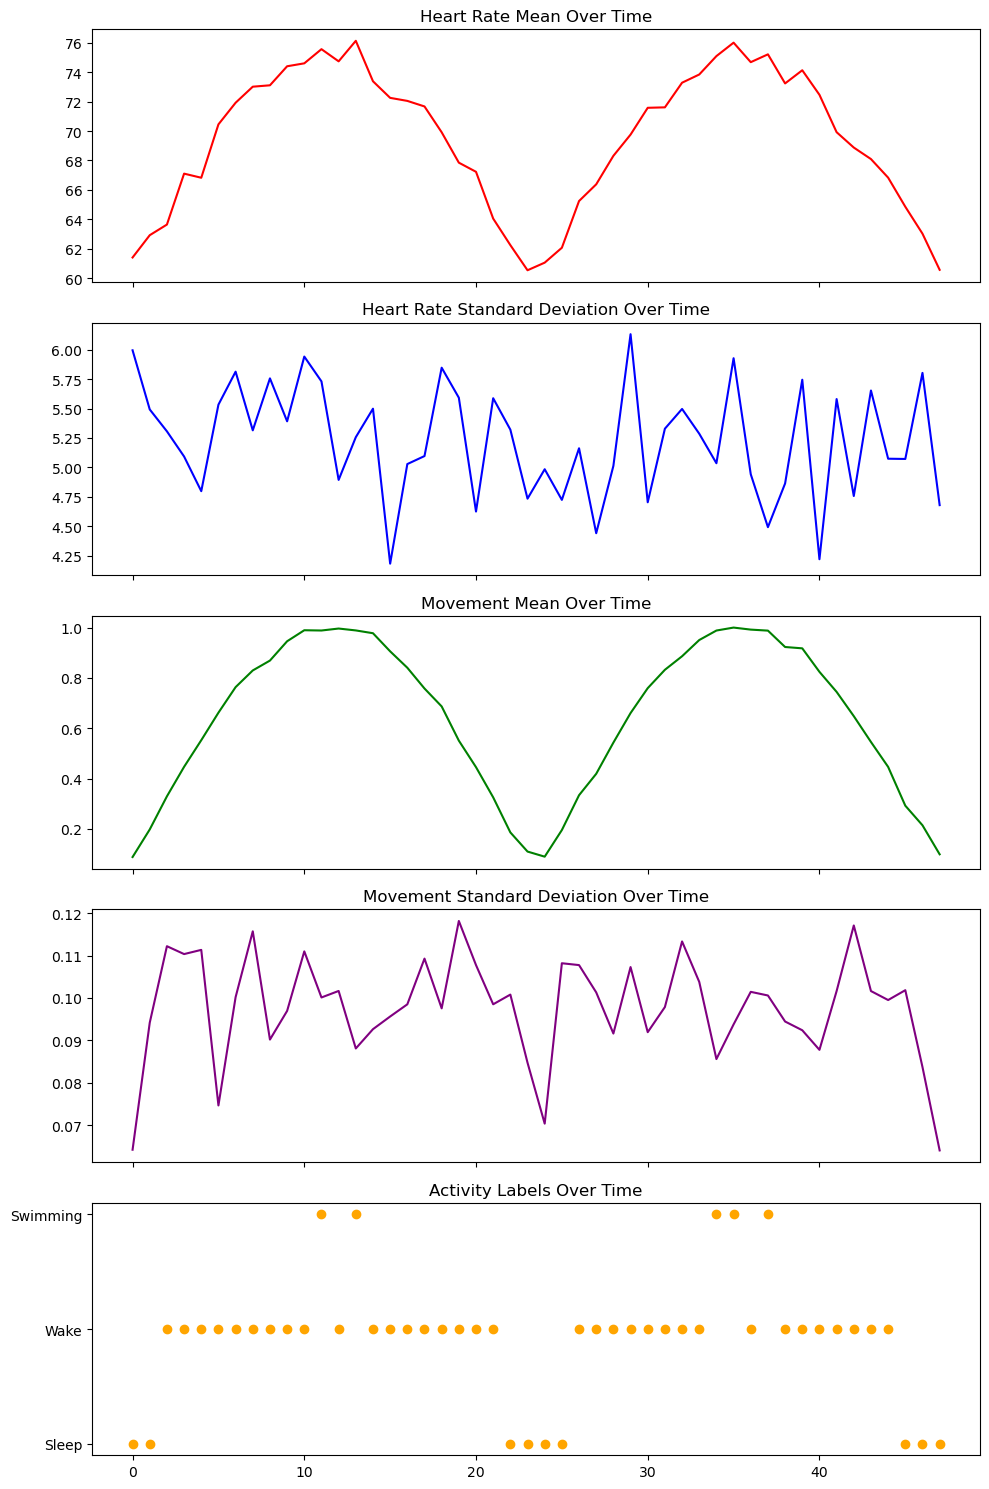

In [28]:
# Plotting the data with labels
fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

# Heart rate mean
axs[0].plot(feature_vectors.index, feature_vectors['Heart rate mean'], label='Heart rate mean', color='red')
axs[0].set_title('Heart Rate Mean Over Time')

# Heart rate std
axs[1].plot(feature_vectors.index, feature_vectors['Heart rate std'], label='Heart rate std', color='blue')
axs[1].set_title('Heart Rate Standard Deviation Over Time')

# Movement mean
axs[2].plot(feature_vectors.index, feature_vectors['Movement mean'], label='Movement mean', color='green')
axs[2].set_title('Movement Mean Over Time')

# Movement std
axs[3].plot(feature_vectors.index, feature_vectors['Movement std'], label='Movement std', color='purple')
axs[3].set_title('Movement Standard Deviation Over Time')

# Activity labels
axs[4].scatter(feature_vectors.index, feature_vectors['Activity'], color='orange', label='Activity Label')
axs[4].set_title('Activity Labels Over Time')
axs[4].set_yticks([0, 1, 2])
axs[4].set_yticklabels(choices)

plt.tight_layout()
plt.show()


In [34]:
# Step 1: Generate synthetic data
# X, y = make_classification(n_samples=500, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X = feature_vectors[['Heart rate mean', 'Heart rate std', 'Movement mean', 'Movement std']]
y = feature_vectors['Activity'].map({'Sleep': 0, 'Wake': 1, 'Swimming': 2})  # Encoding labels


In [41]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
feature_vectors.head()

,Heart rate mean,Heart rate std,Movement mean,Movement std,Activity
0,61.403191,5.994991,0.088181,0.064180,Sleep
1,62.919077,5.492107,0.197859,0.094166,Sleep
2,63.641686,5.306072,0.329476,0.112217,Wake
3,67.103947,5.092085,0.446819,0.110357,Wake
4,66.824987,4.797376,0.552623,0.111348,Wake


# Train LGBM

In [56]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


# Step 2: Train a LightGBM model
# model = lgb.LGBMClassifier(n_estimators=10, learning_rate=0.1, num_leaves=2, random_state=42)
model = lgb.LGBMClassifier(
    n_estimators=10, 
    learning_rate=0.01, 
    num_leaves=2, 
    random_state=42, 
    min_data_in_bin=1, 
    min_data_in_leaf=1
)


model.fit(X_train, y_train)

# Step 3: Extract and plot feature importances
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 33, number of used features: 4
[LightGBM] [Info] Start training from score -1.550597
[LightGBM] [Info] Start training from score -0.405465
[LightGBM] [Info] Start training from score -2.110213


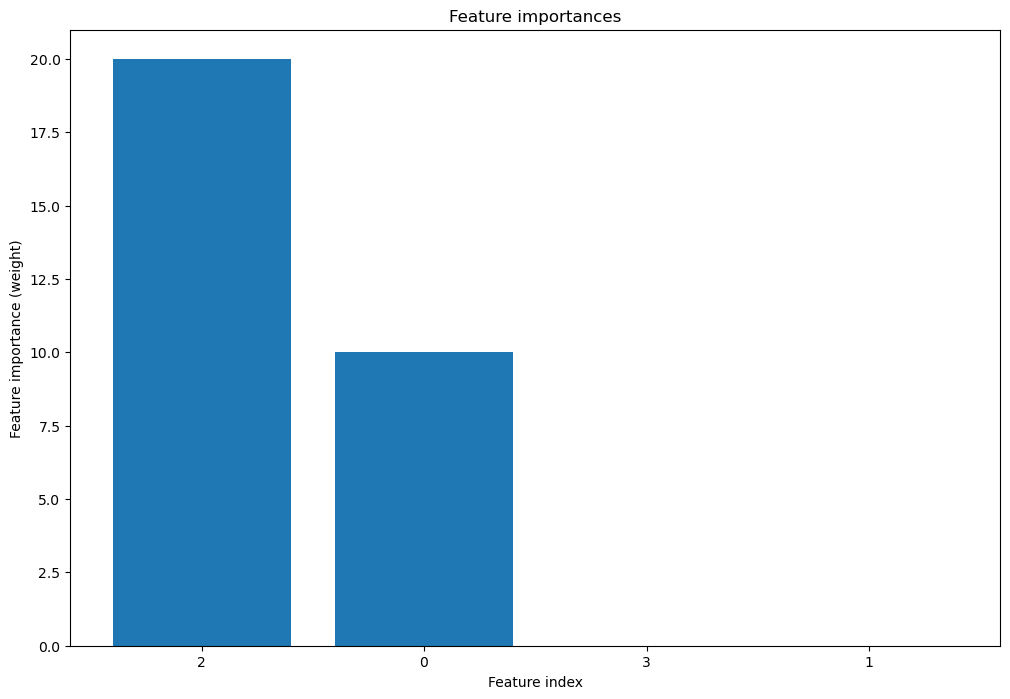

In [57]:
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel("Feature index")
plt.ylabel("Feature importance (weight)")
plt.show()